In [1]:
import nibabel as nib
import nilearn as nil
import numpy as np 
import sys
from scipy.cluster.hierarchy import fcluster, linkage
from scipy.spatial.distance import pdist
sys.path.append("/home/cerebriu/data/RESEARCH/MicrobleedNet/src/utils/")

import utils.utils_processing as utils_process
import utils.utils_datasets as utils_datasets
import os
from typing import Tuple, List, Dict


In [2]:

subject = "1.2.826.1.3680043.9.5282.150415.14832.16014832222376"
input_dir = "/home/cerebriu/data/datasets/raw/CEREBRIU_cmb"

sequences_raw, labels_raw, sequence_type, seq_folder = utils_datasets.load_CEREBRIU_raw(input_dir, subject)
tasks_dict = utils_datasets.read_json_to_dict(os.path.join(f"/home/cerebriu/data/datasets/raw/CEREBRIU_cmb/{subject}", "tasks.json"))

task_item = [it for it in tasks_dict if it['name'] == subject][0]
series_data = [seq for seq in task_item['series'] if seq['name'] == seq_folder][0] 


print(labels_raw)
label_im = labels_raw[sequence_type]
label_data = label_im.get_fdata()
mri_im = sequences_raw[sequence_type]
mri_data = mri_im.get_fdata()

# Parsing segmentMap
extracted_data = {
    "segmentMap": series_data.get("segmentMap", {}),
    "landmarks3d": series_data.get("landmarks3d", []),
    "sequence_meta": series_data.get("classifications", []),
    "study_meta": task_item.get("classification", [])

}

assert extracted_data["segmentMap"], "segmentMap is empty"
msg = ""

size_th = utils_process.calculate_size_threshold(label_im)
print()
label_mask_all = np.zeros_like(label_im.get_fdata(), dtype=bool)
all_seeds = []
rg_metadata_all = []
label_mask_list = []
# for labelid, mask_dict in extracted_data["segmentMap"].items():
idx='5'
# for labelid, mask_dict in [(str(idx), extracted_data["segmentMap"][idx])]:
for labelid, mask_dict in extracted_data["segmentMap"].items():

    print(labelid)
    multiple = mask_dict['attributes'].get('Multiple', 'false') == 'True'
    msg += f"Processing label {labelid} with {'multiple' if multiple else 'single'} CMB annotations.\n"
    
    # Convert max_dist_mm to voxel distance
    max_dist_mm = 9
    voxel_size = np.mean(label_im.header.get_zooms())  # Adjust as needed
    max_dist_voxels = max_dist_mm / voxel_size
    
    label_mask, raw_mask, seeds, cmb_metadata, msg = utils_datasets.process_CEREBRIU_cmb(
        label_im, labelid, mri_im, size_th, max_dist_voxels, msg, multiple)

    # Check for overlap
    if np.any(label_mask_all & label_mask):
        raise RuntimeError("Overlap detected between different CMB annotated masks")

    label_mask_all |= label_mask
    all_seeds.append(seeds)
    rg_metadata_all.append(cmb_metadata)
    label_mask_list.append(label_mask)

annotation_processed_nib = nib.Nifti1Image(label_mask_all.astype(np.int16), label_im.affine, label_im.header)
processed_mask_nib, metadata, msg = utils_process.process_cmb_mask(annotation_processed_nib, msg)



nib.save(
    mri_im, "/home/cerebriu/Downloads/brain.nii.gz"
)

nib.save(
    label_im, "/home/cerebriu/Downloads/before.nii.gz"
)
nib.save(
    annotation_processed_nib, "/home/cerebriu/Downloads/after.nii.gz"
)


{'T2S': <nibabel.nifti1.Nifti1Image object at 0x7f1e230334d0>}

1


Looping over tolerances:  60%|██████    | 180/300 [00:03<00:02, 45.70it/s]


2


Looping over tolerances:  25%|██▍       | 74/300 [00:00<00:01, 154.45it/s]


3


Looping over tolerances:  62%|██████▏   | 186/300 [00:01<00:00, 130.77it/s]


4


Looping over tolerances:  43%|████▎     | 130/300 [00:00<00:00, 187.15it/s]


5


Looping over tolerances:  23%|██▎       | 68/300 [00:00<00:02, 83.89it/s] 


6


Looping over tolerances:  55%|█████▌    | 166/300 [00:01<00:00, 153.70it/s]


7


Looping over tolerances:  71%|███████   | 212/300 [00:01<00:00, 203.78it/s]


8


Looping over tolerances:  43%|████▎     | 128/300 [00:00<00:00, 172.31it/s]


9


Looping over tolerances:  63%|██████▎   | 190/300 [00:00<00:00, 233.09it/s]


10


Looping over tolerances:  61%|██████    | 182/300 [00:00<00:00, 316.34it/s]


11


Looping over tolerances:  40%|████      | 120/300 [00:01<00:02, 79.34it/s]


12


Looping over tolerances:  67%|██████▋   | 202/300 [00:02<00:01, 72.47it/s] 


In [3]:
mask_dict

{'category': 'CMB',
 'attributes': {'<5mm': True},
 'mask': '/home/cerebriu/data/datasets/raw/CEREBRIU_cmb/1.2.826.1.3680043.9.5282.150415.14832.16014832222376/segmentations/1.2.826.1.3680043.9.5282.150415.14832.16014832222376/T2S_0.nii.gz'}

In [4]:
print(msg)

Processing label 1 with single CMB annotations.
			Number of CMBs found in label id 1: 1.
			Processed CMB 0. n_seeds=2, new_size=26
Processing label 2 with single CMB annotations.
			Number of CMBs found in label id 2: 1.
			Processed CMB 0. n_seeds=1, new_size=1
Processing label 3 with single CMB annotations.
			Number of CMBs found in label id 3: 1.
			Processed CMB 0. n_seeds=1, new_size=4
Processing label 4 with single CMB annotations.
			Number of CMBs found in label id 4: 1.
			Processed CMB 0. n_seeds=1, new_size=4
Processing label 5 with single CMB annotations.
			Number of CMBs found in label id 5: 1.
			Processed CMB 0. n_seeds=1, new_size=20
Processing label 6 with single CMB annotations.
			Number of CMBs found in label id 6: 1.
			Processed CMB 0. n_seeds=1, new_size=4
Processing label 7 with single CMB annotations.
			Number of CMBs found in label id 7: 1.
			Processed CMB 0. n_seeds=1, new_size=4
Processing label 8 with single CMB annotations.
			Number of CMBs found in

In [5]:
mask_dict

{'category': 'CMB',
 'attributes': {'<5mm': True},
 'mask': '/home/cerebriu/data/datasets/raw/CEREBRIU_cmb/1.2.826.1.3680043.9.5282.150415.14832.16014832222376/segmentations/1.2.826.1.3680043.9.5282.150415.14832.16014832222376/T2S_0.nii.gz'}

In [6]:
all_seeds


[[(110, 186, 23), (110, 187, 23)],
 [(121, 214, 24)],
 [(145, 159, 24)],
 [(148, 134, 25)],
 [(144, 162, 25)],
 [(147, 79, 23)],
 [(98, 104, 11)],
 [(178, 105, 11)],
 [(173, 95, 11)],
 [(176, 88, 11)],
 [(182, 97, 11)],
 [(115, 173, 24)]]

181
179
[{'n_pixels': 26, 'tolerance_selected': 89.5, 'tolerance_pixel_counts': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, 5, 5, 5, 5, 5, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 22, 22, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 195], 'tolerances_inspected': 181, 'elbow_i': 179}]


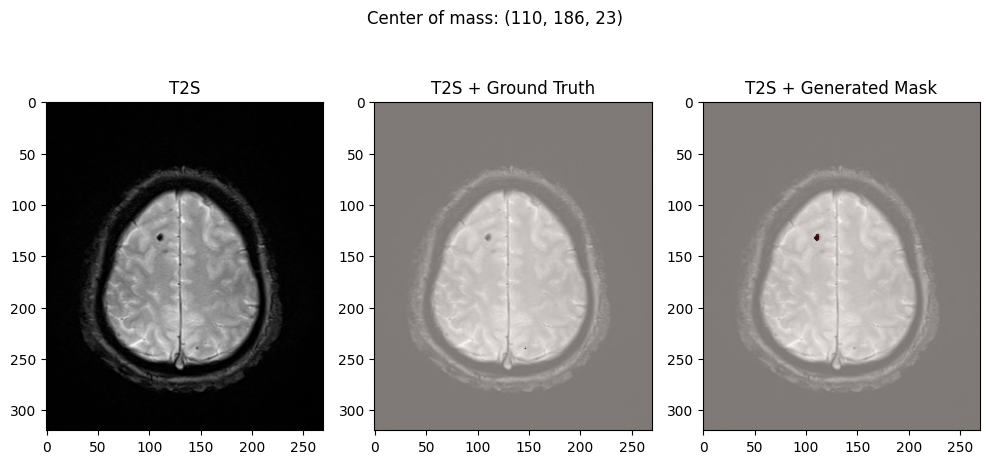

75
73
[{'n_pixels': 1, 'tolerance_selected': 36.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 195], 'tolerances_inspected': 75, 'elbow_i': 73}]


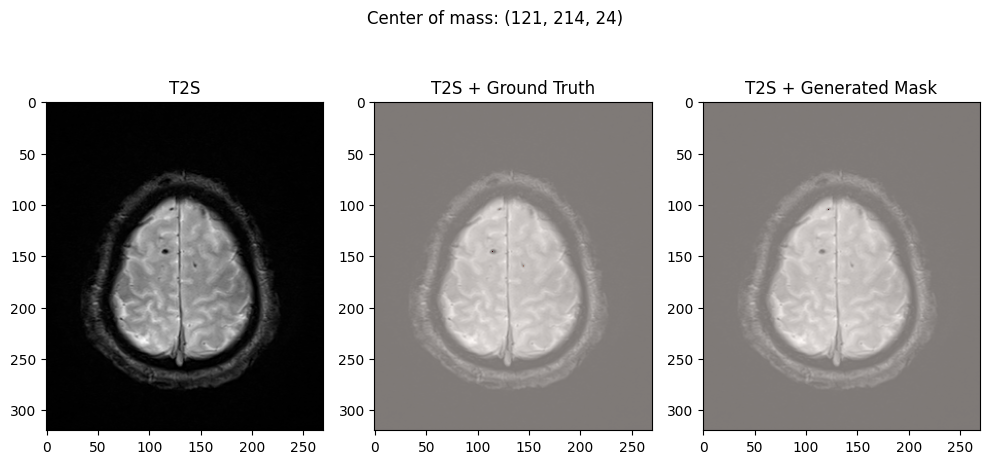

187
185
[{'n_pixels': 4, 'tolerance_selected': 92.5, 'tolerance_pixel_counts': [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 195], 'tolerances_inspected': 187, 'elbow_i': 185}]


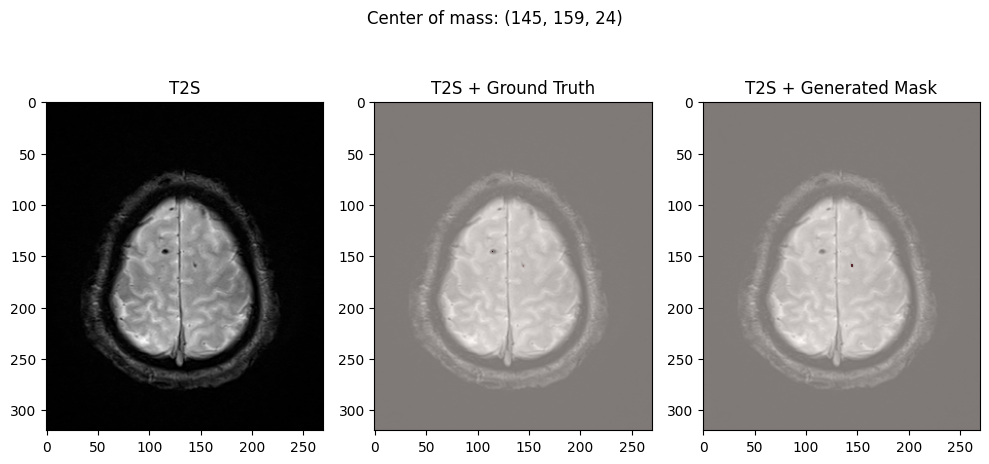

131
129
[{'n_pixels': 4, 'tolerance_selected': 64.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 195], 'tolerances_inspected': 131, 'elbow_i': 129}]


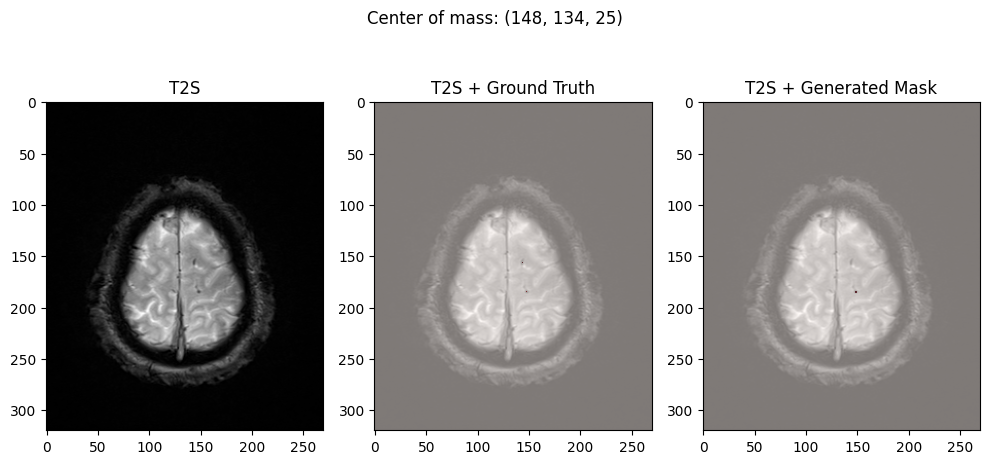

69
67
[{'n_pixels': 20, 'tolerance_selected': 33.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 14, 14, 15, 15, 20, 20, 195], 'tolerances_inspected': 69, 'elbow_i': 67}]


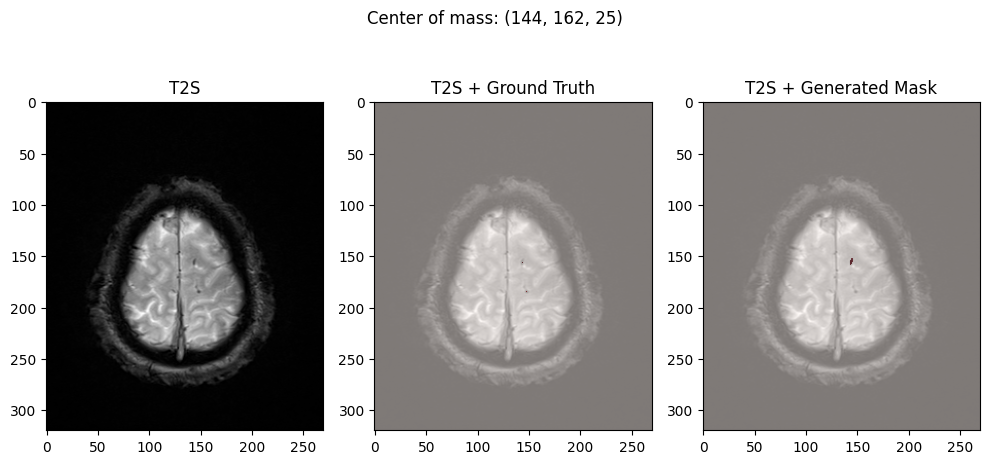

167
165
[{'n_pixels': 4, 'tolerance_selected': 82.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 195], 'tolerances_inspected': 167, 'elbow_i': 165}]


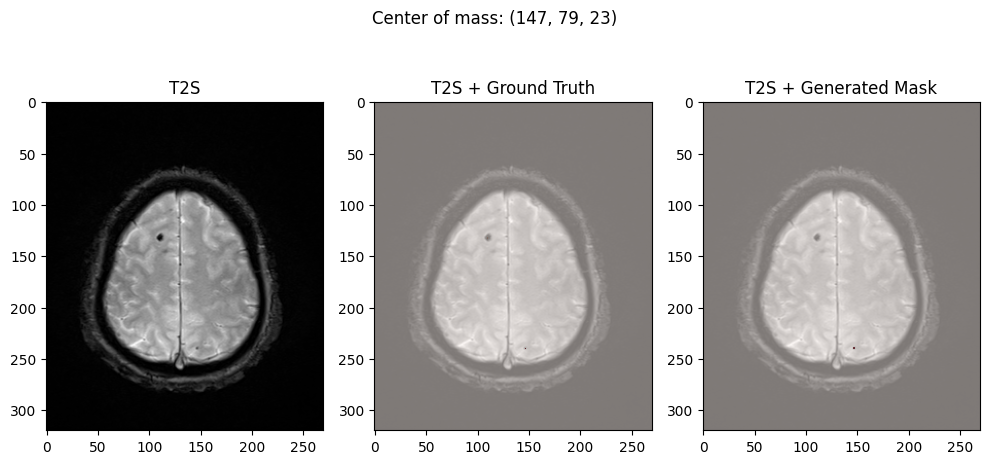

213
211
[{'n_pixels': 4, 'tolerance_selected': 105.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 195], 'tolerances_inspected': 213, 'elbow_i': 211}]


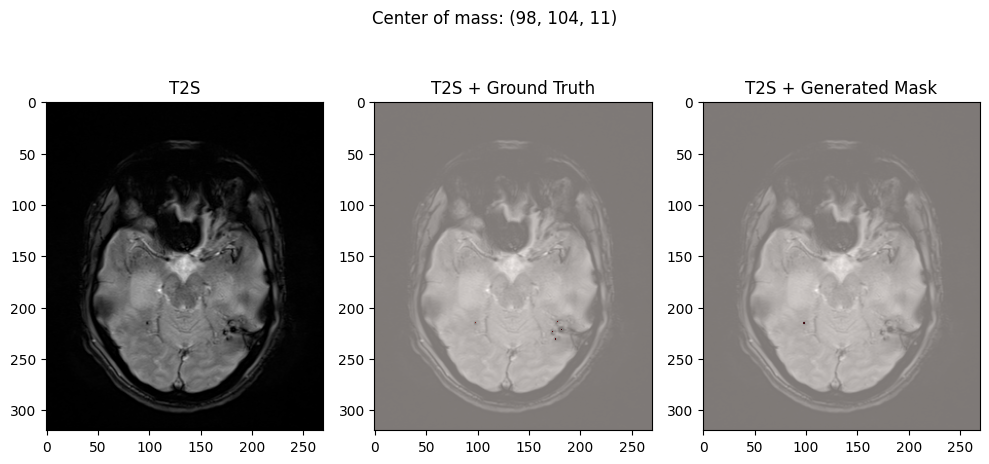

129
127
[{'n_pixels': 7, 'tolerance_selected': 63.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 7, 7, 195], 'tolerances_inspected': 129, 'elbow_i': 127}]


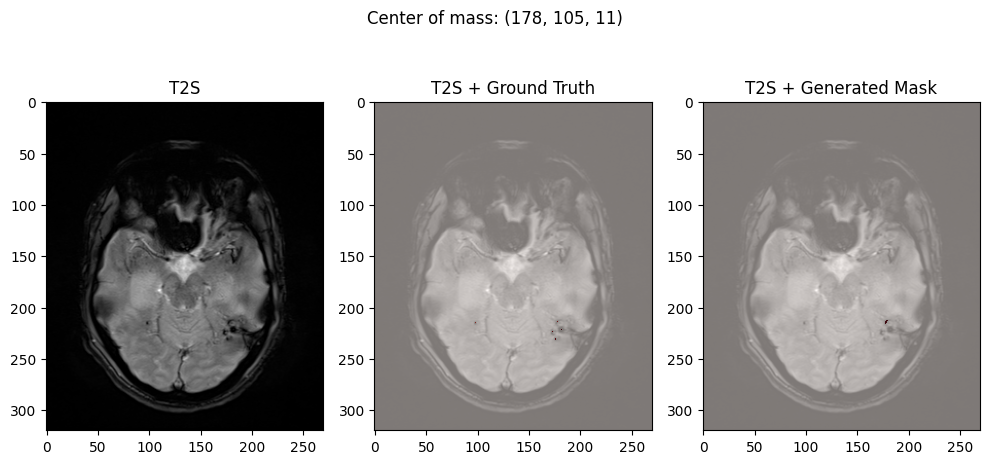

191
189
[{'n_pixels': 10, 'tolerance_selected': 94.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 195], 'tolerances_inspected': 191, 'elbow_i': 189}]


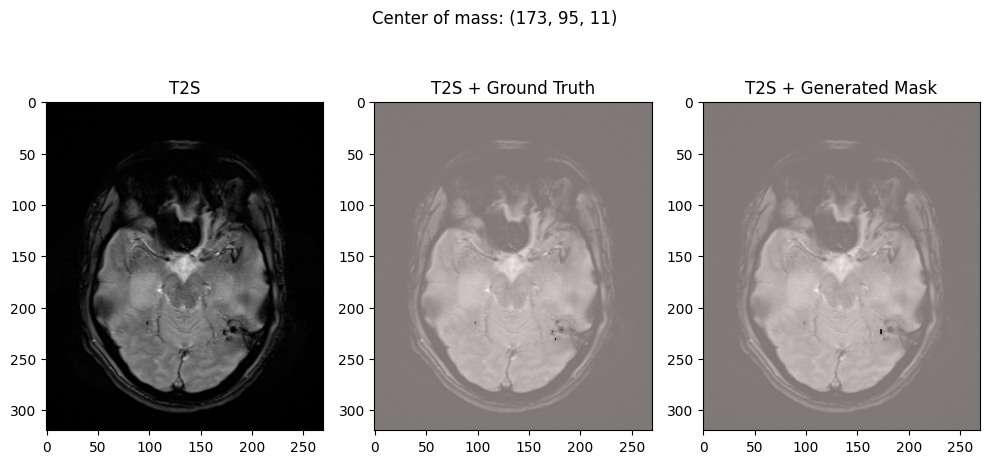

183
181
[{'n_pixels': 1, 'tolerance_selected': 90.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 195], 'tolerances_inspected': 183, 'elbow_i': 181}]


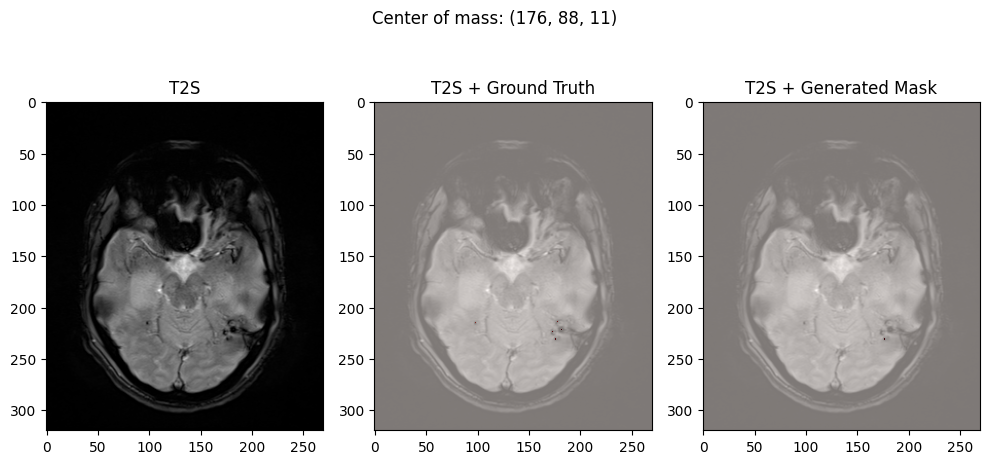

121
119
[{'n_pixels': 20, 'tolerance_selected': 59.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 195], 'tolerances_inspected': 121, 'elbow_i': 119}]


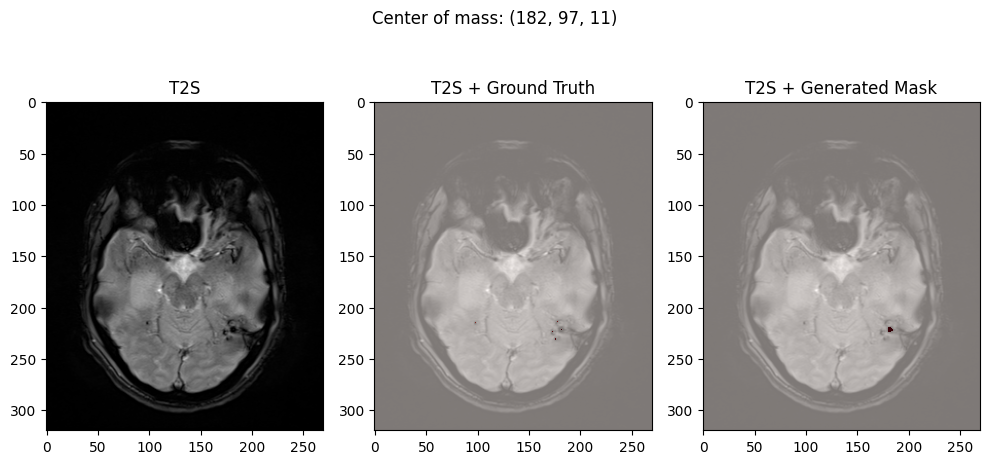

203
201
[{'n_pixels': 15, 'tolerance_selected': 100.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 195], 'tolerances_inspected': 203, 'elbow_i': 201}]


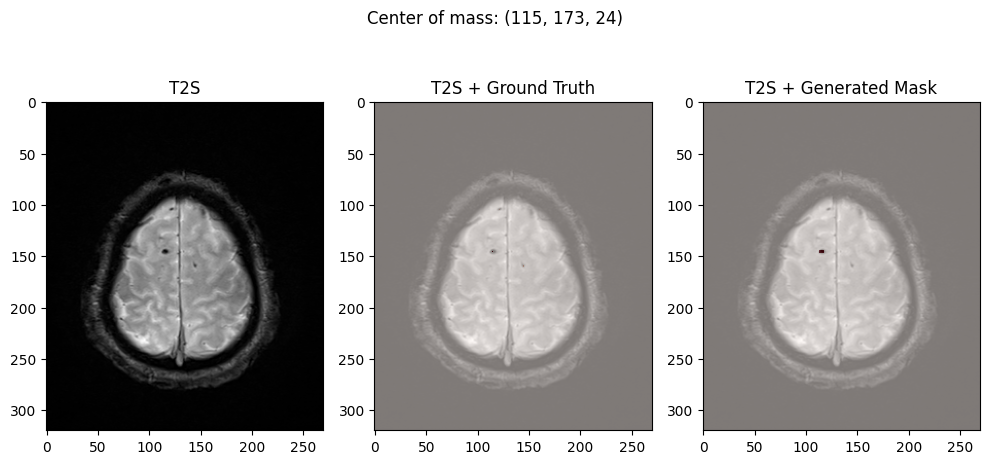

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming t2s_data, cmb_data, and out_mask are numpy arrays from results_dict
t2s_data, cmb_data, out_mask = mri_im.get_fdata(), label_im.get_fdata(), processed_mask_nib.get_fdata()
CMs = metadata['centers_of_mass']

# for i in range(len(CMs)):
for ss, mm, lab in zip(all_seeds, rg_metadata_all, label_mask_list):

    out_mask = lab
    for CM, met in zip(ss, mm):
        print(mm[0]['tolerances_inspected'])
        print(mm[0]['elbow_i'])
        print(mm)
        # Creating a figure with three subplots
        fig, axs = plt.subplots(1, 3, figsize=(10, 5))

        # Function to adjust the image for radiological view
        def adjust_for_radiological_view(image):
            return np.rot90(image)

        # Plotting raw T2 image
        axs[0].imshow(adjust_for_radiological_view(t2s_data[:, :, CM[-1]]), cmap='gray')
        axs[0].set_title('T2S')

        # Plotting ground truth overlay
        axs[1].imshow(adjust_for_radiological_view(t2s_data[:, :, CM[-1]]), cmap='gray')
        axs[1].imshow(adjust_for_radiological_view(cmb_data[:, :, CM[-1]]), alpha=0.5, cmap="Reds", interpolation='none')
        axs[1].set_title('T2S + Ground Truth')

        # Plotting generated mask
        axs[2].imshow(adjust_for_radiological_view(t2s_data[:, :, CM[-1]]), cmap='gray')
        axs[2].imshow(adjust_for_radiological_view(out_mask[:, :, CM[-1]]), alpha=0.5, cmap="Reds", interpolation='none')
        axs[2].set_title('T2S + Generated Mask')

        # # Removing axes for cleaner look
        # for ax in axs:
        #     ax.axis('off')
            
        fig.suptitle(f"Center of mass: {CM}")

        plt.tight_layout()
        # Display the plots
        plt.show()